# Libraries

In [2]:
import json
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=4)
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Plot function

In [34]:
def corrner_id_angles(angle_array,identified_corners,dim,pose,gap,img):
    """ CORNER IDENTIFICATION """
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    plt.scatter(angle_array.T[0], angle_array.T[1], 
                color='blue',marker='+')
    plt.scatter(identified_corners.T[0],identified_corners.T[1],
                color='red',marker='+',label='identified corners')
    plt.ylabel(r'$\theta_R$')
    plt.xlabel(r'$\theta_L$')
    plt.legend(loc='lower right')
    #plt.savefig("corner_id_snd_deriv_1sqr_sim.png")

def corrner_id_time_series(angle_array,class_array,identified_corner,dim,pose,gap,img):
    """ TIME SERIES """
    """ CORNER IDENTIFICATION """
    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots()
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = (12,8)
    plt.plot(angle_array.T[1], angle_array.T[0], color='red',label=r'$\theta_L$')
    plt.plot(angle_array.T[3], angle_array.T[2], color='blue',label=r'$\theta_R$')
    #plt.scatter(time_corners.T[0],identified_corners.T[0], 
    #        color='red',marker='+',label='identified corners')
    #plt.scatter(time_corners.T[1], identified_corners.T[1], 
    #        color='red',marker='+',label='identified corners')
    plt.scatter(angle_array.T[1][class_array == 'corner'], 
                angle_array.T[0][class_array == 'corner'], 
                s=100, color='orange',marker='+',label='corners')
    plt.scatter(angle_array.T[3][class_array == 'corner'], 
                angle_array.T[2][class_array == 'corner'], 
                s=100, color='orange',marker='+')
    plt.scatter(identified_corner[0][1], identified_corner[0][0], 
                s=100, color='green',marker='+',label='identified corners')
    plt.scatter(identified_corner[0][3], identified_corner[0][2], 
                s=100, color='green',marker='+')
    plt.scatter(identified_corner[1][1], identified_corner[1][0], 
                s=100, color='green',marker='+')
    plt.scatter(identified_corner[1][3], identified_corner[1][2], 
                s=100, color='green',marker='+')
    plt.ylabel('position (deg)')
    plt.xlabel('time (s)')
    plt.legend()
    plt.title("Time series square rolling: dim="+str(dim)+'x'+str(dim)+ 'mm ; pose='+str(pose)+'mm ; gap='+str(gap)+'mm ; trial '+str(img),fontsize=20)
    #plt.savefig('2nd_deriv_corner_identification_sqrt_'+str(dim)+'x'+str(dim)+ '_pose_'+str(pose)+'_gap_'+str(gap)+'_'+str(img)+'.png')

# Import data

<ipython-input-34-a14f8d2043e9>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


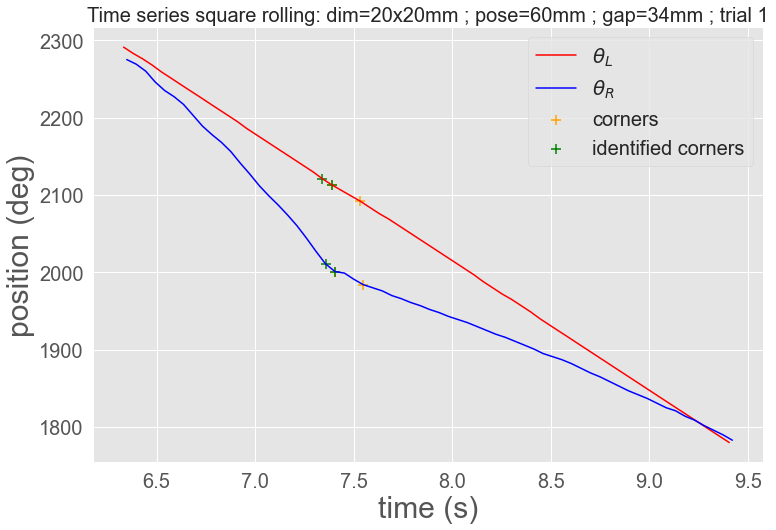

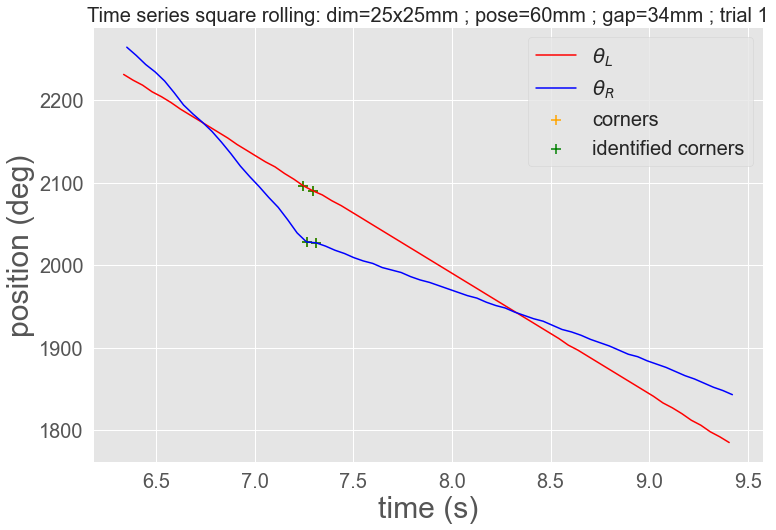

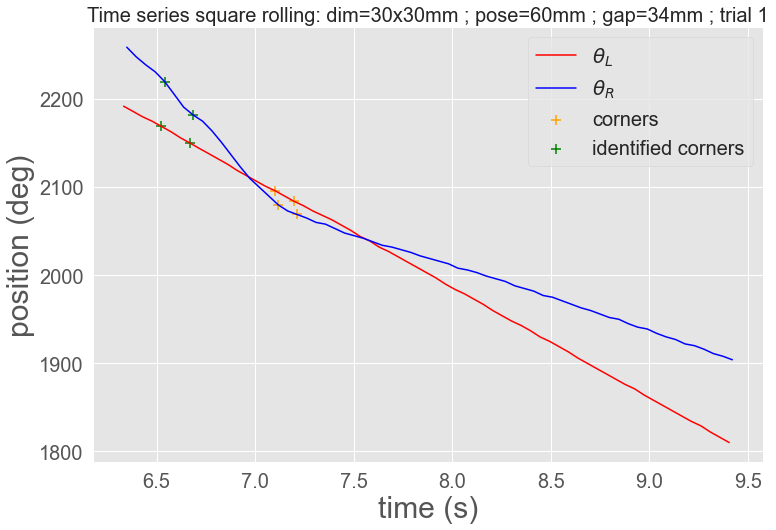

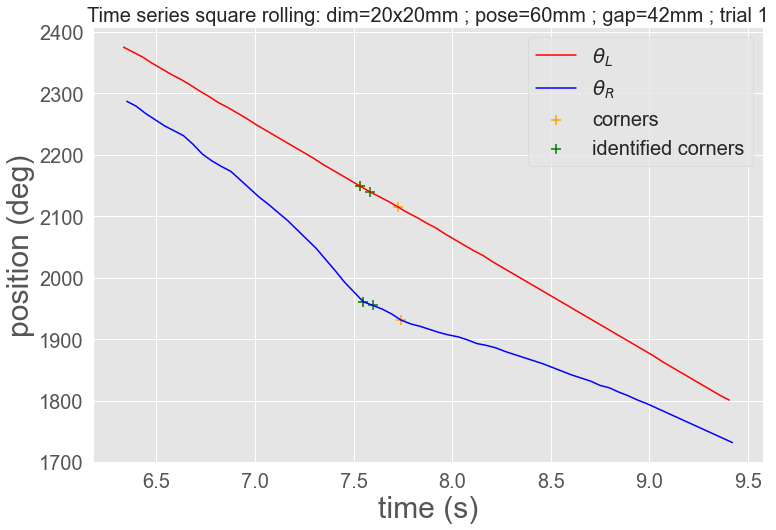

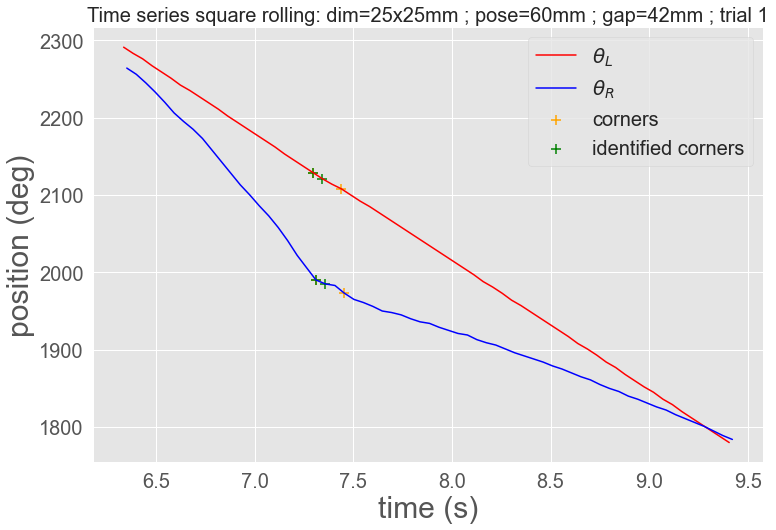

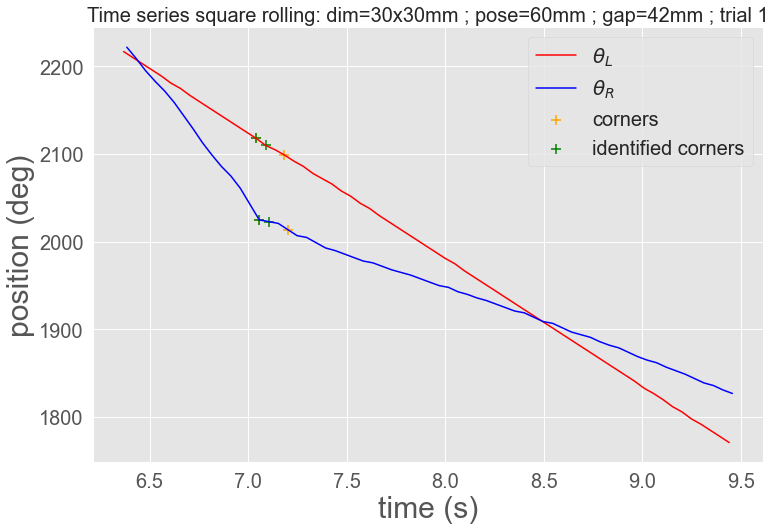

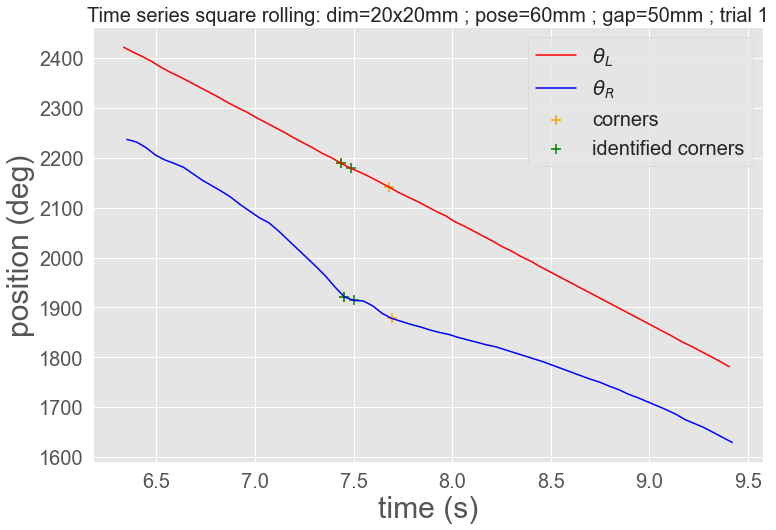

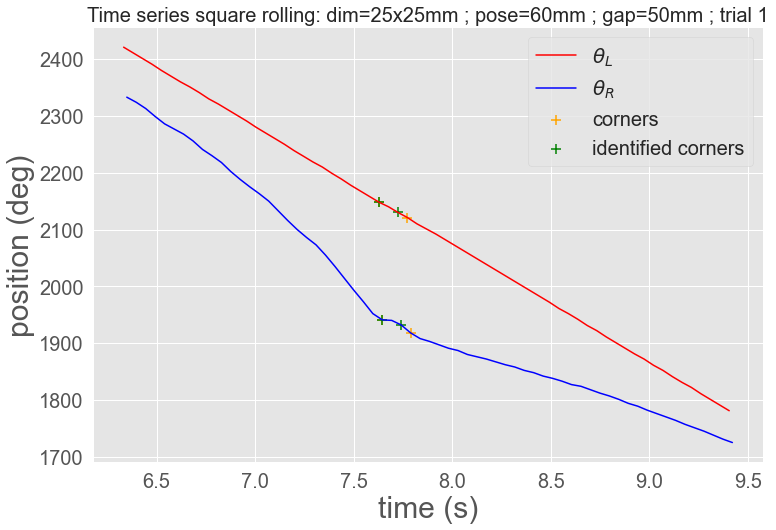

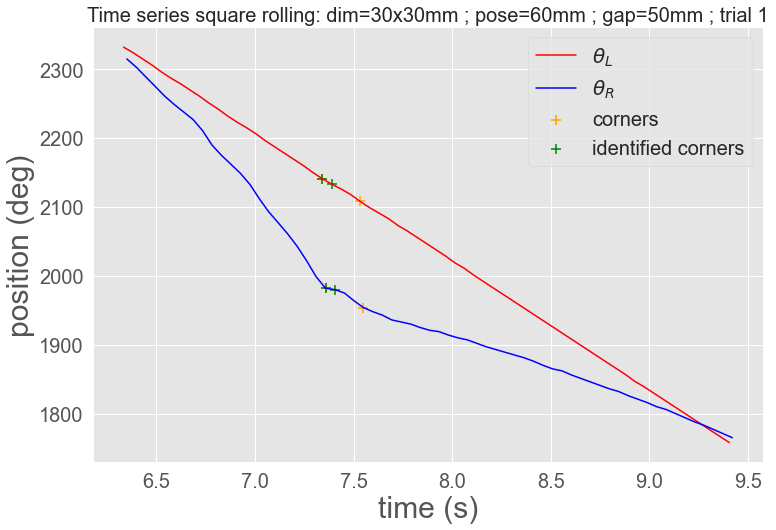

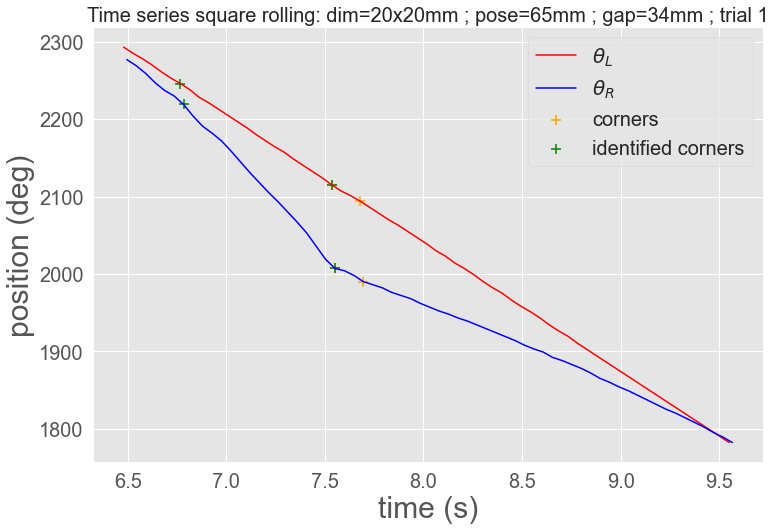

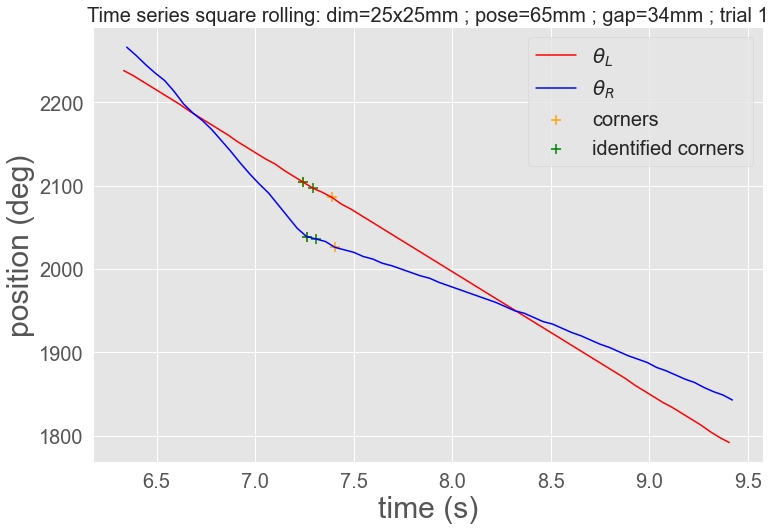

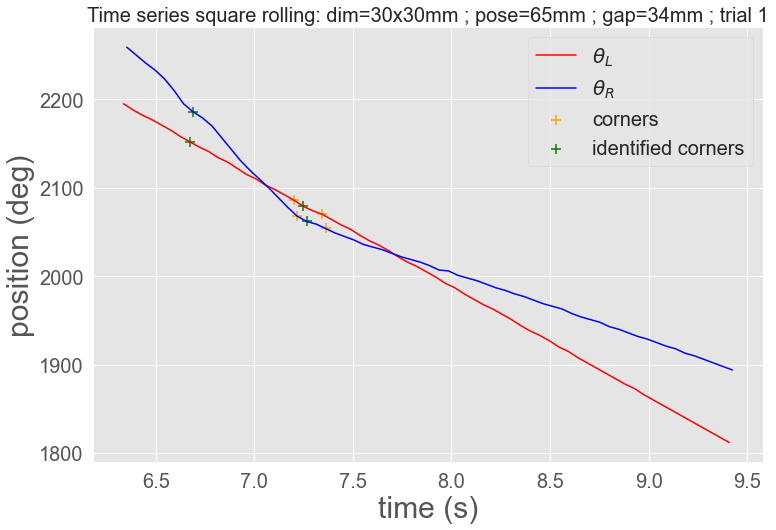

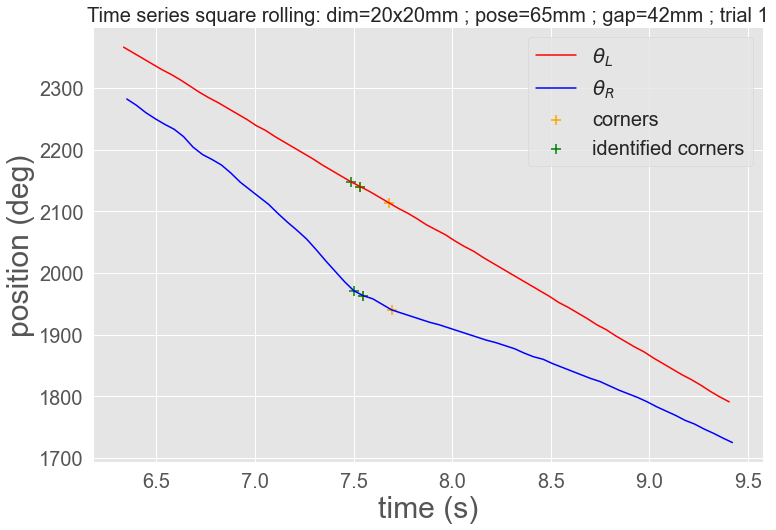

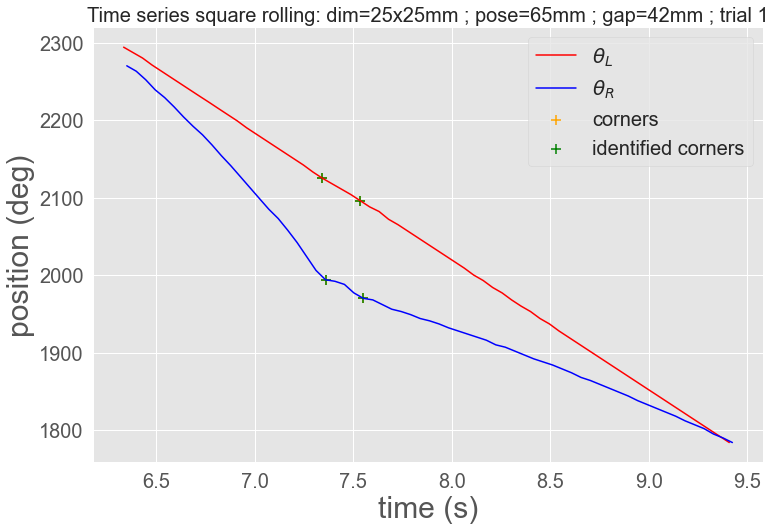

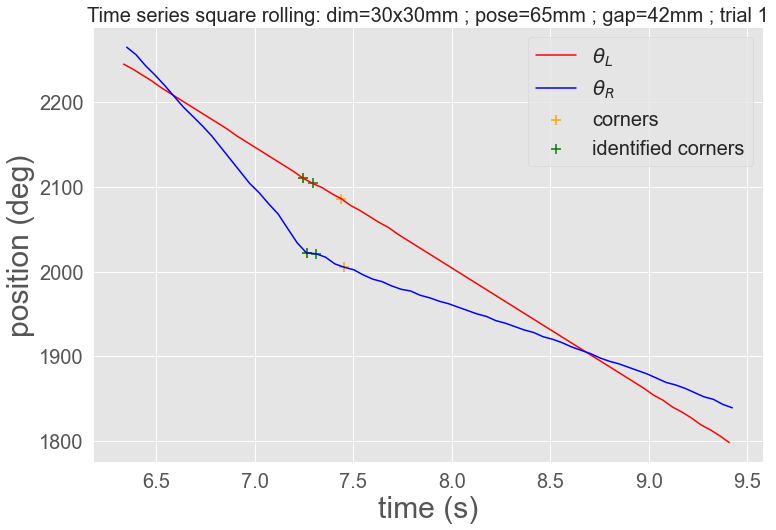

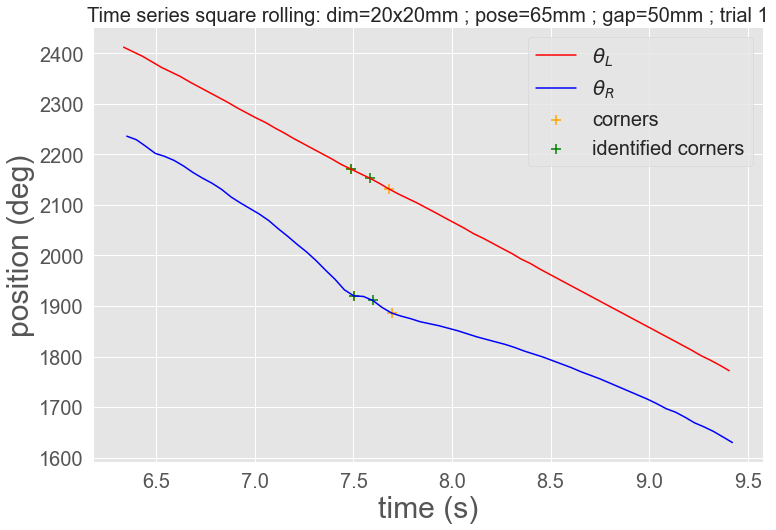

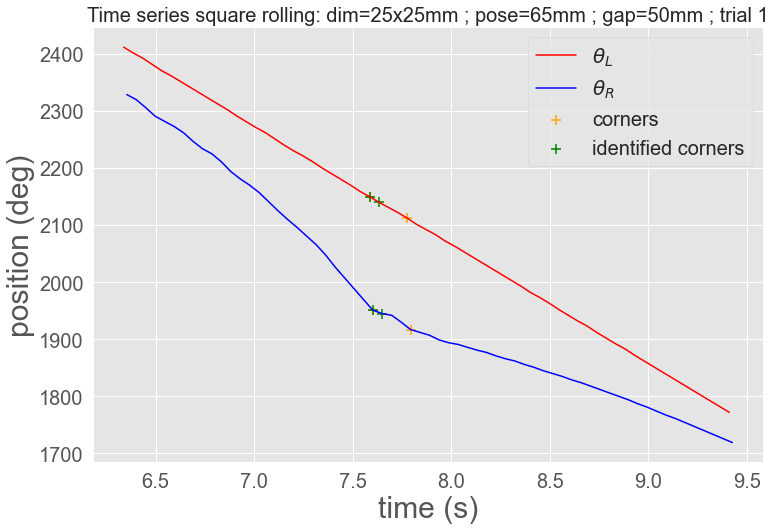

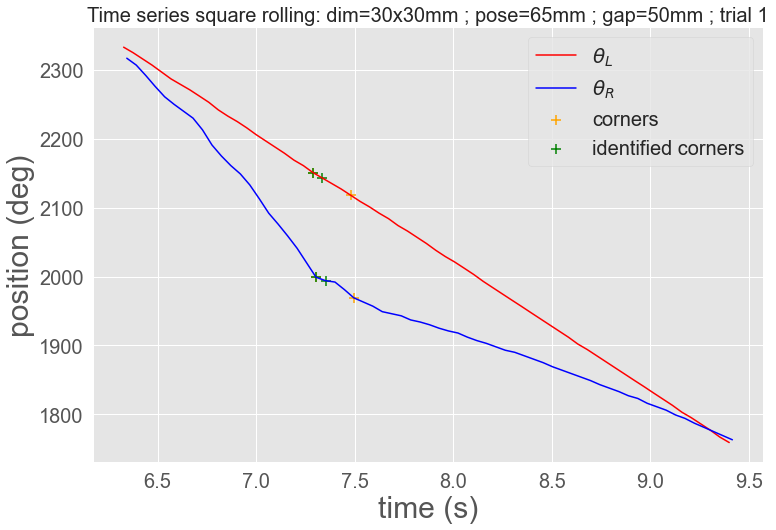

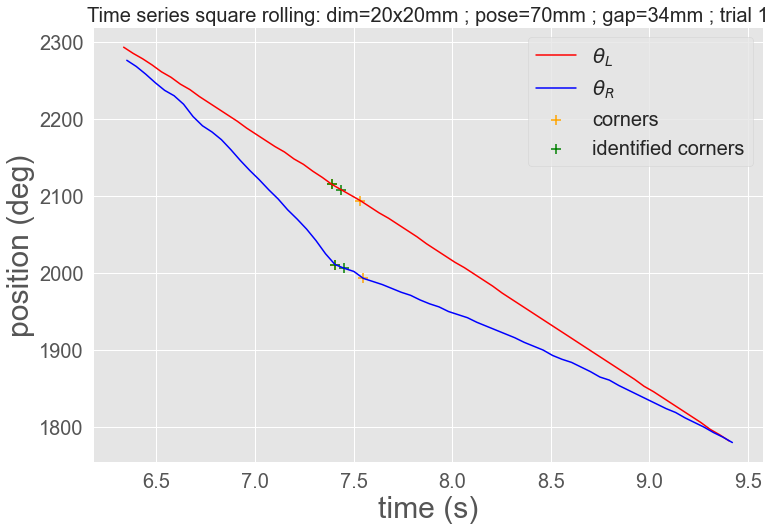

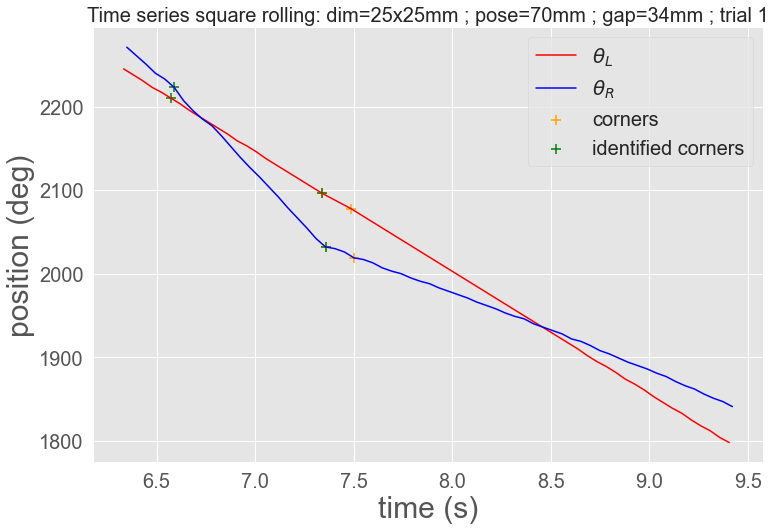

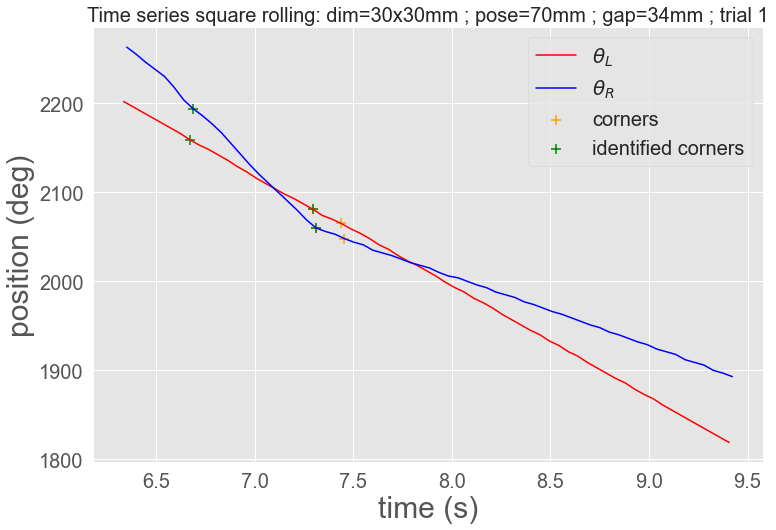

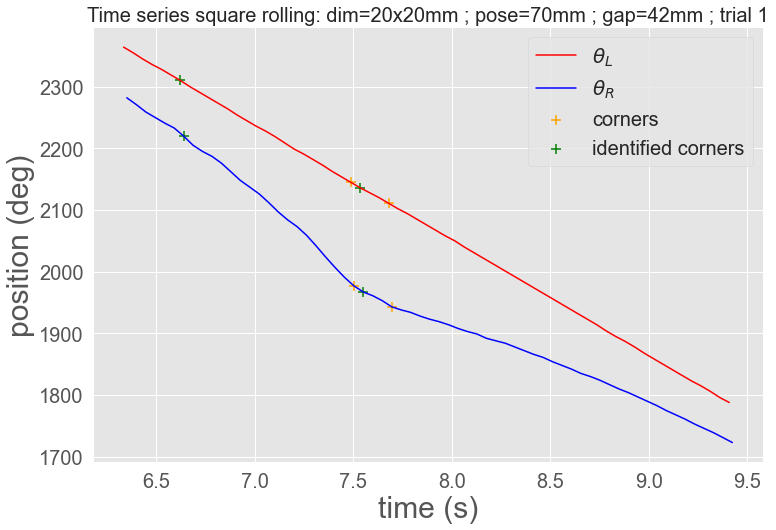

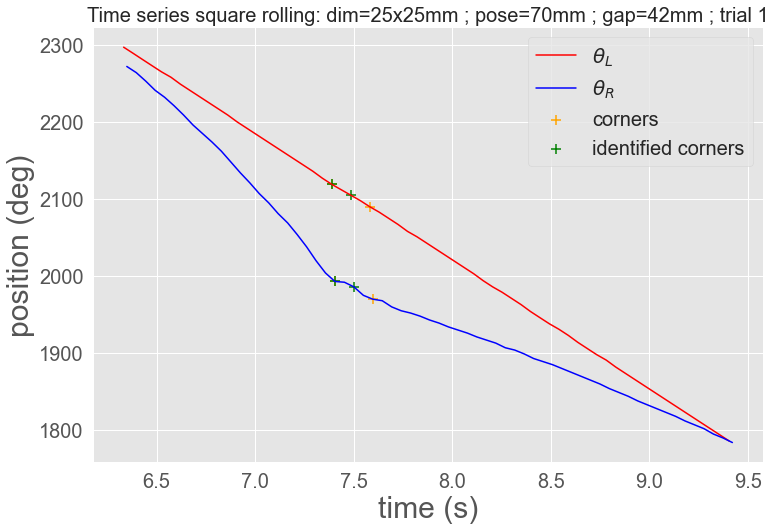

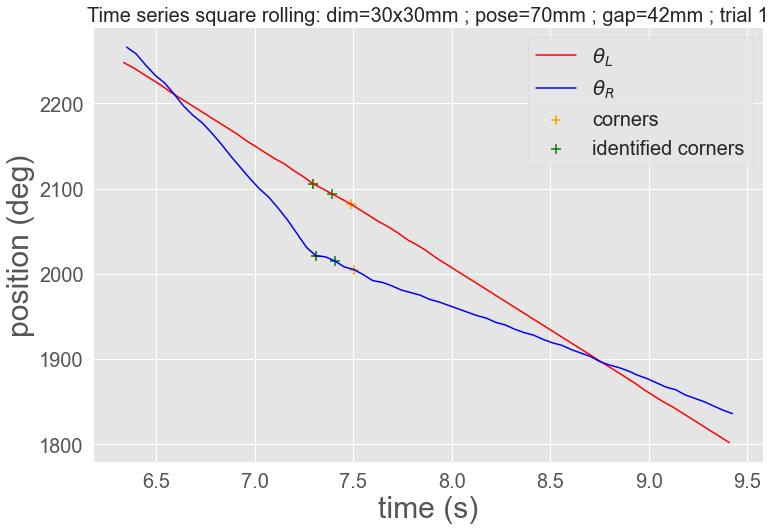

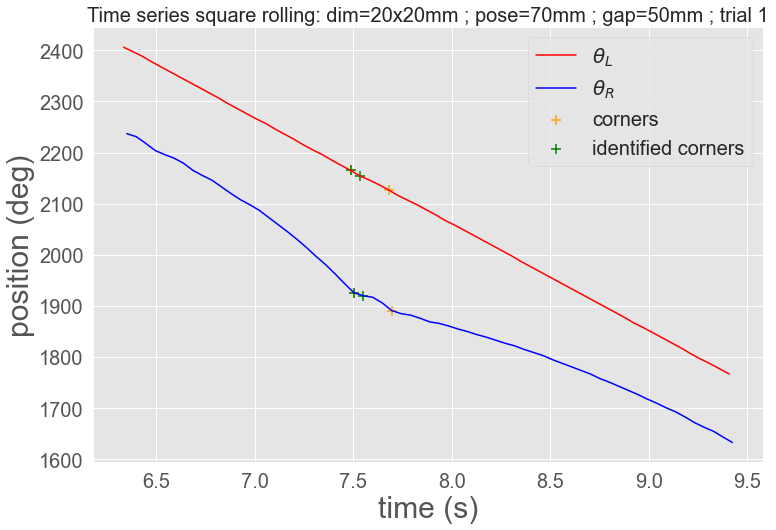

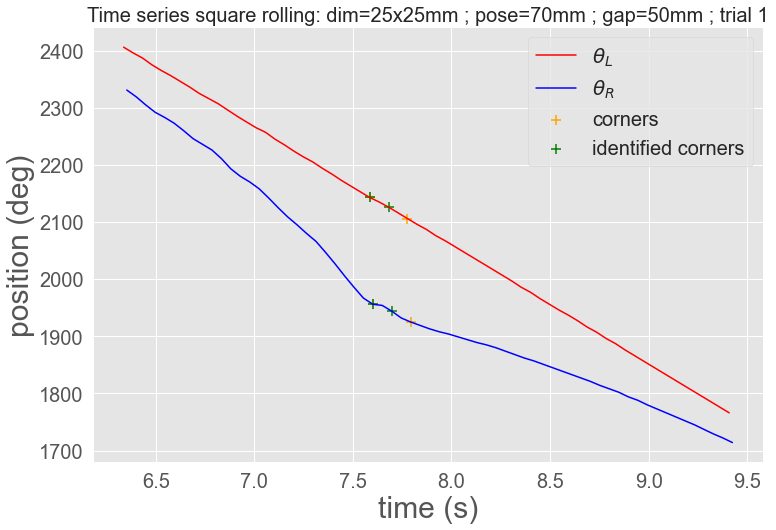

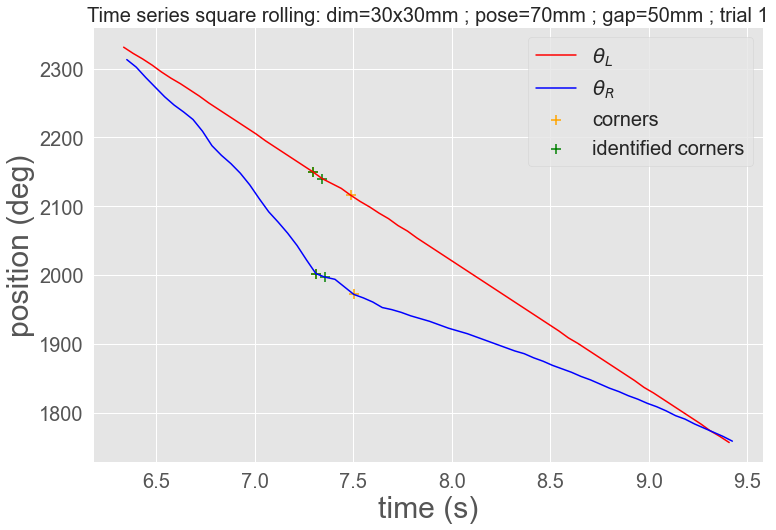

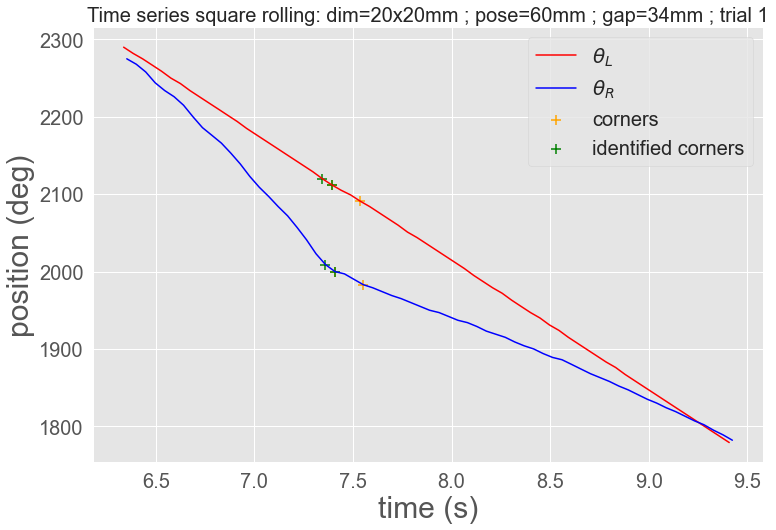

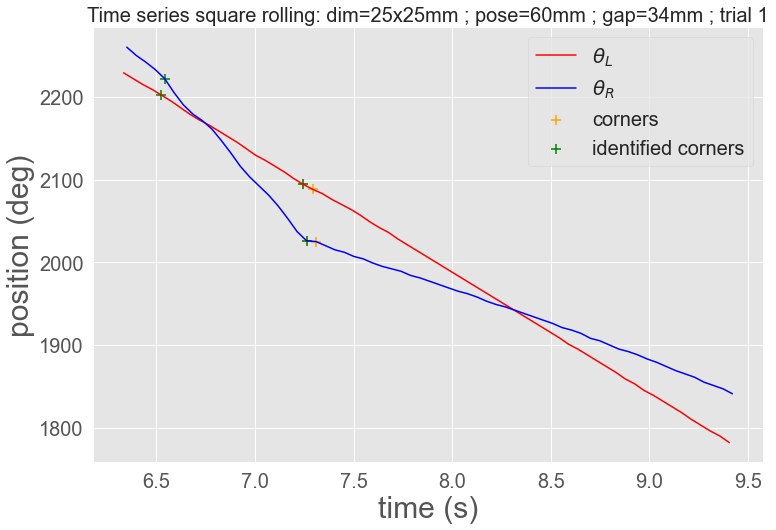

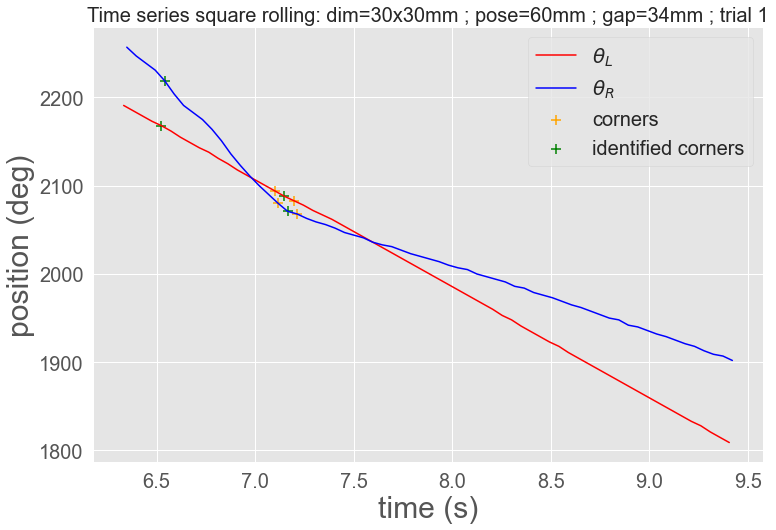

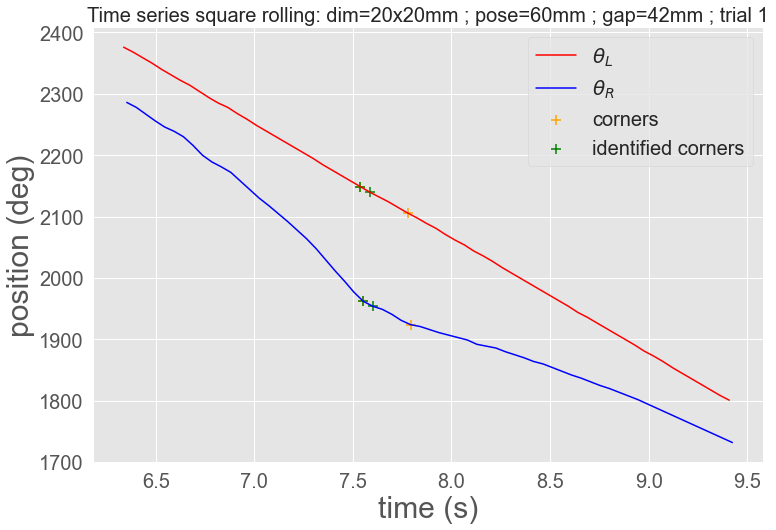

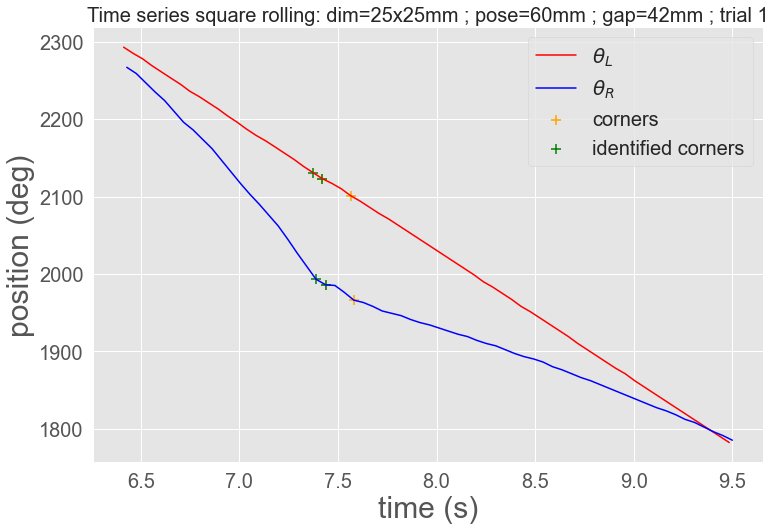

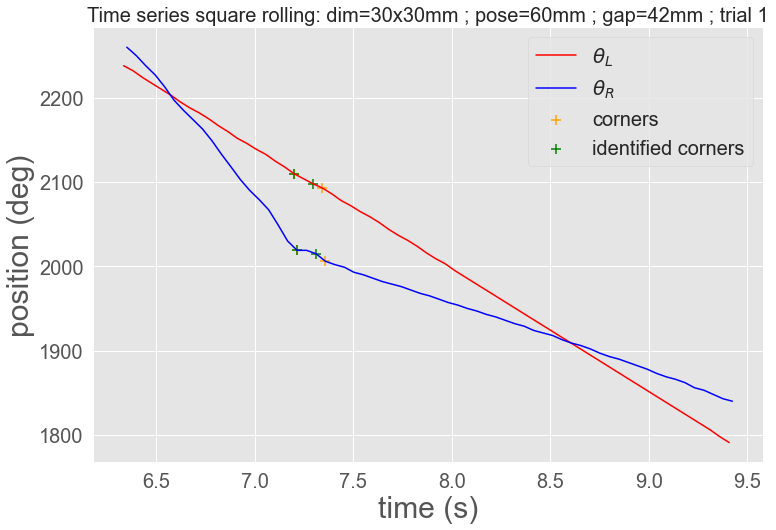

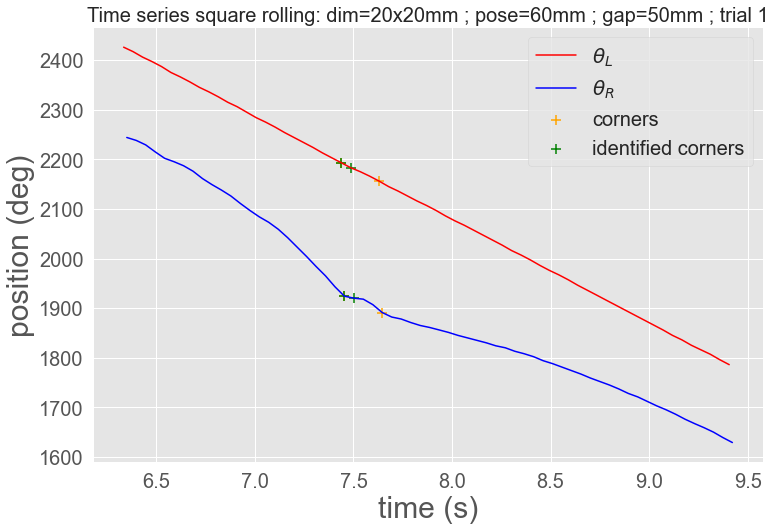

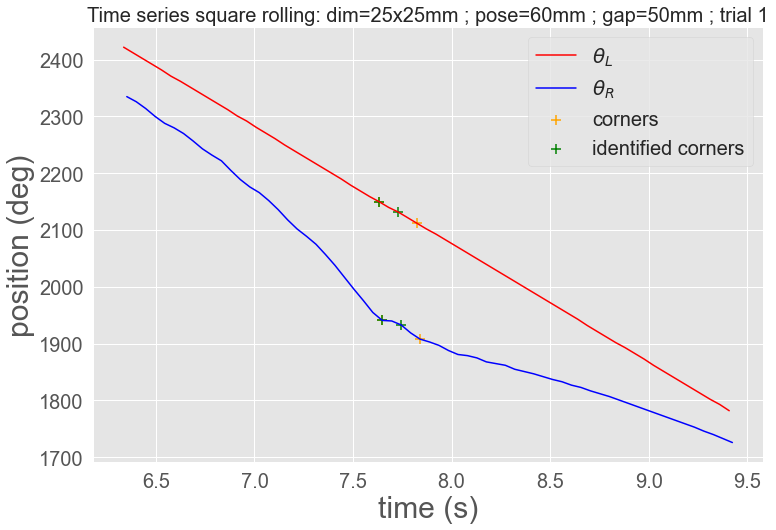

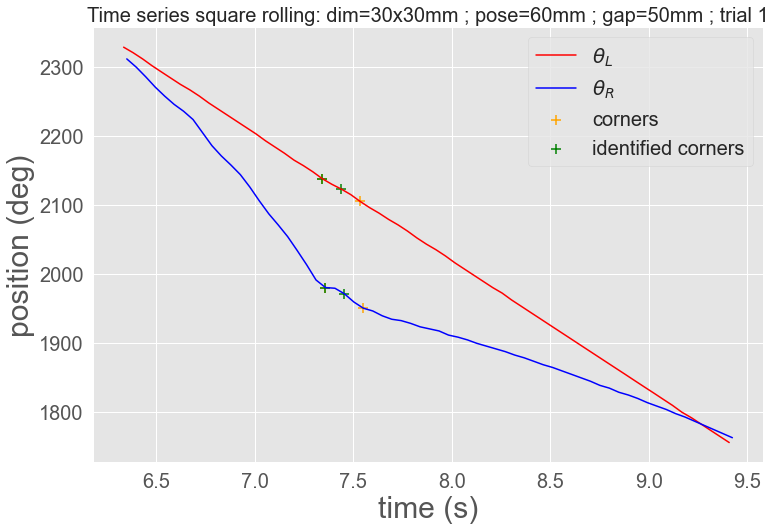

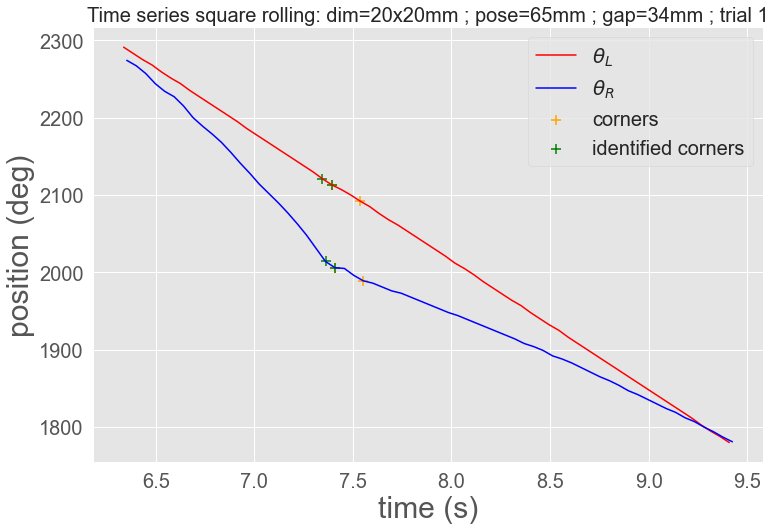

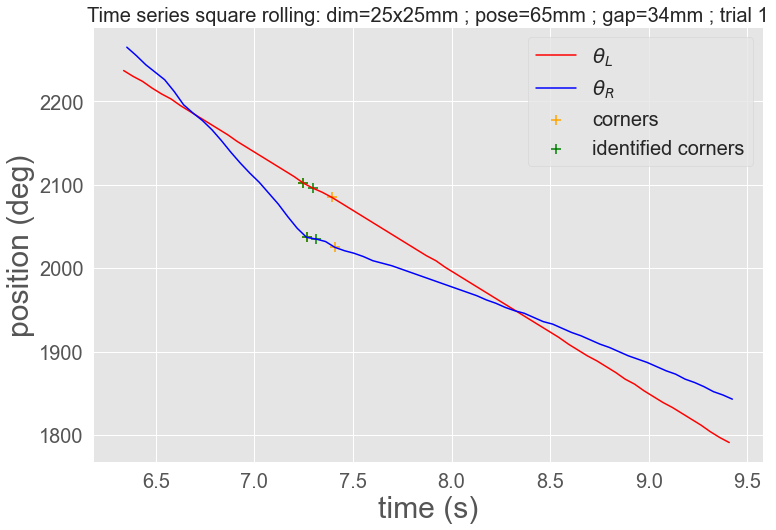

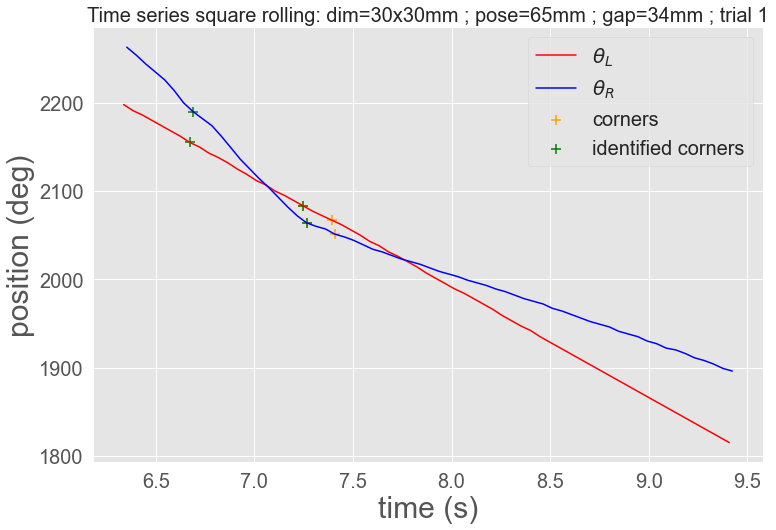

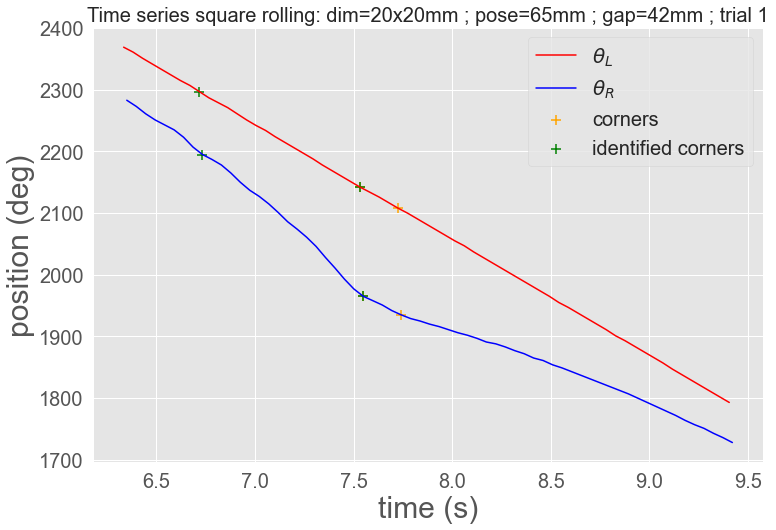

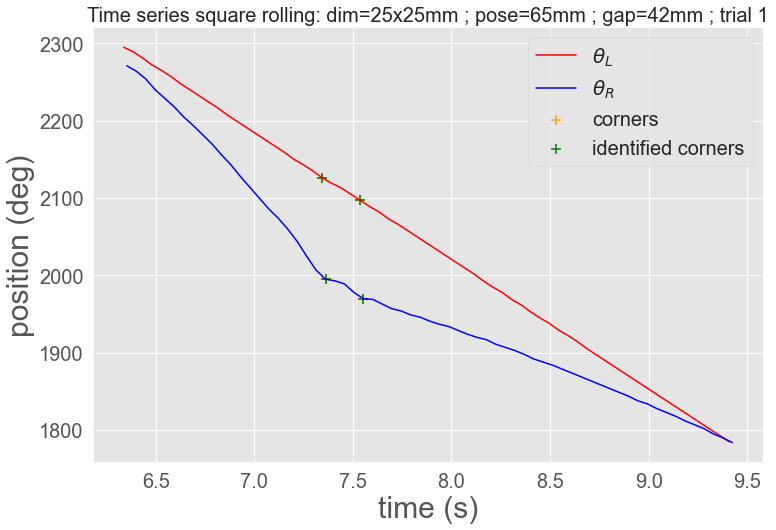

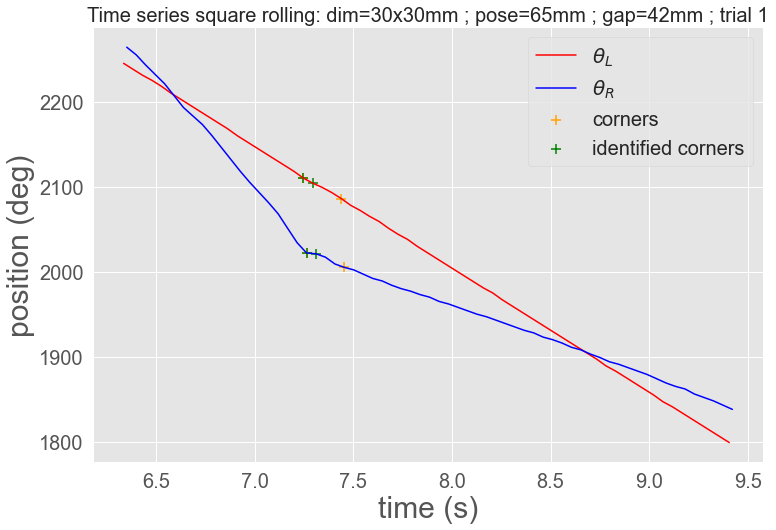

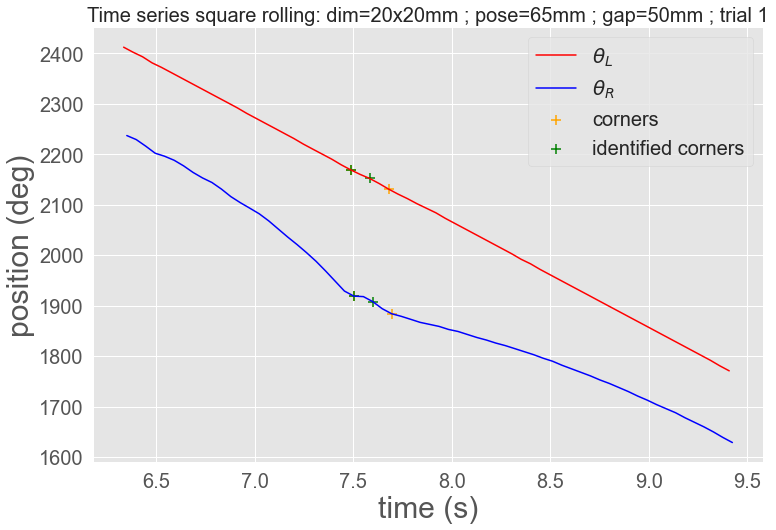

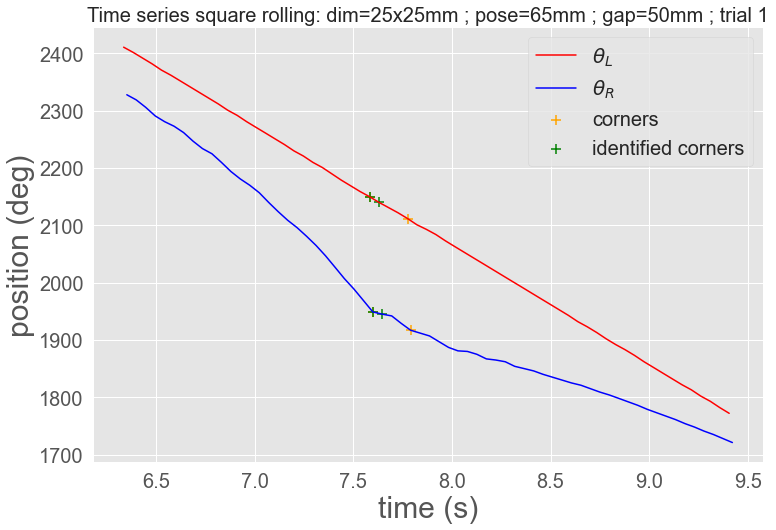

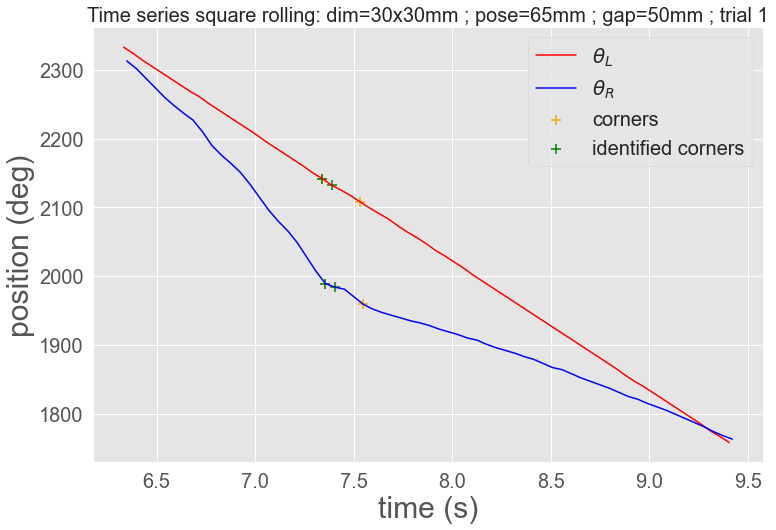

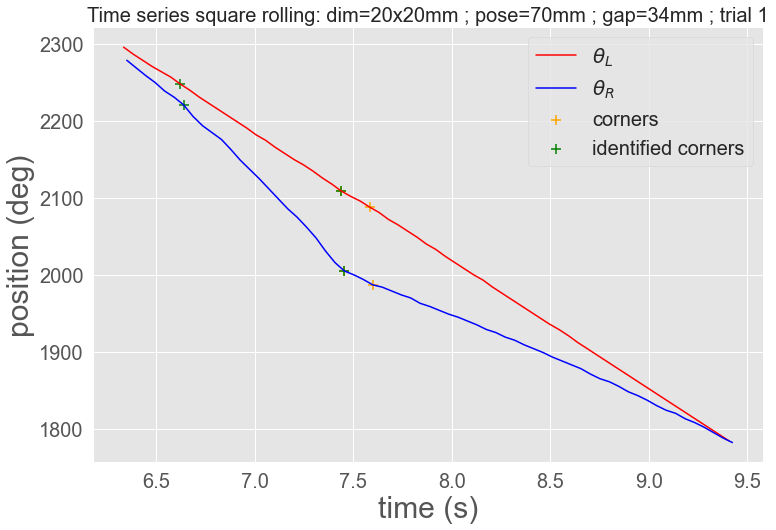

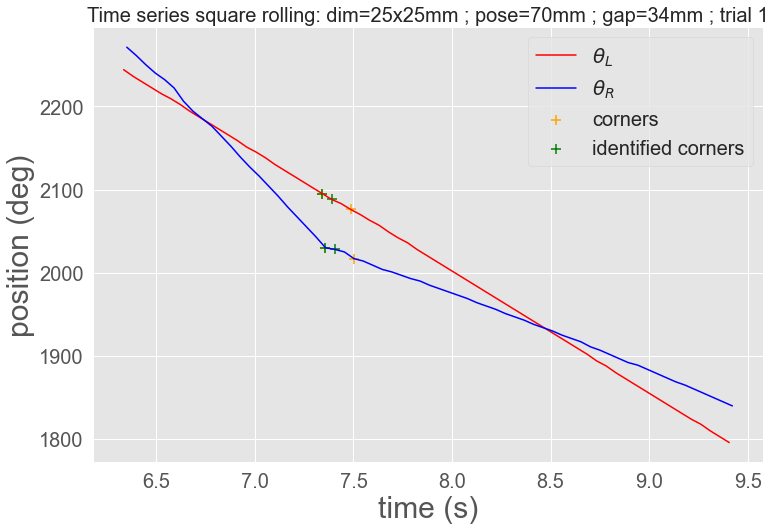

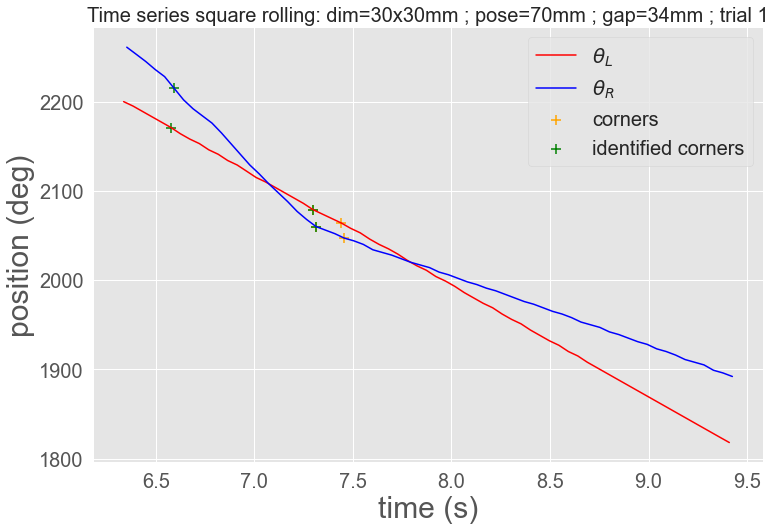

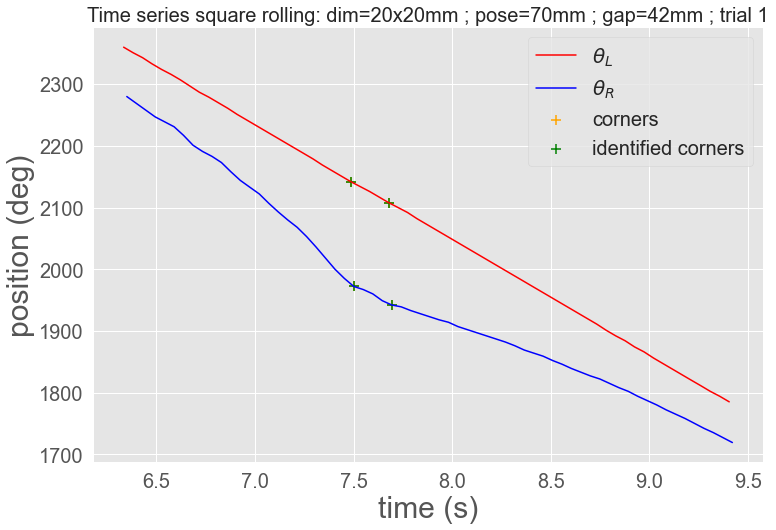

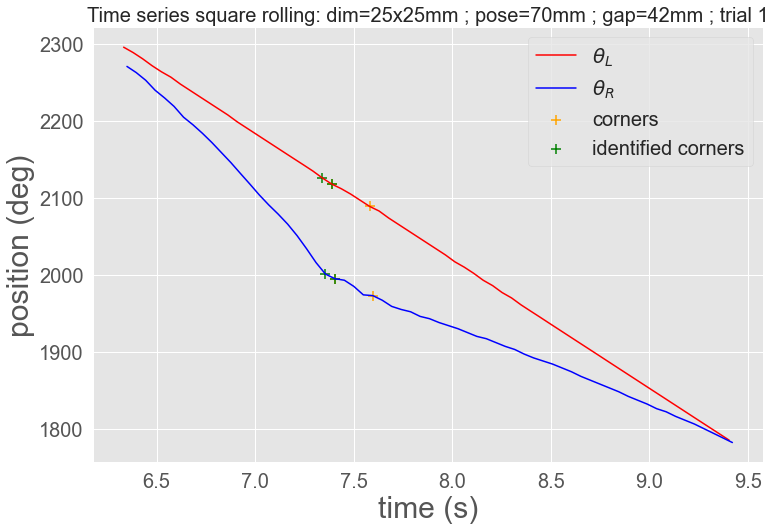

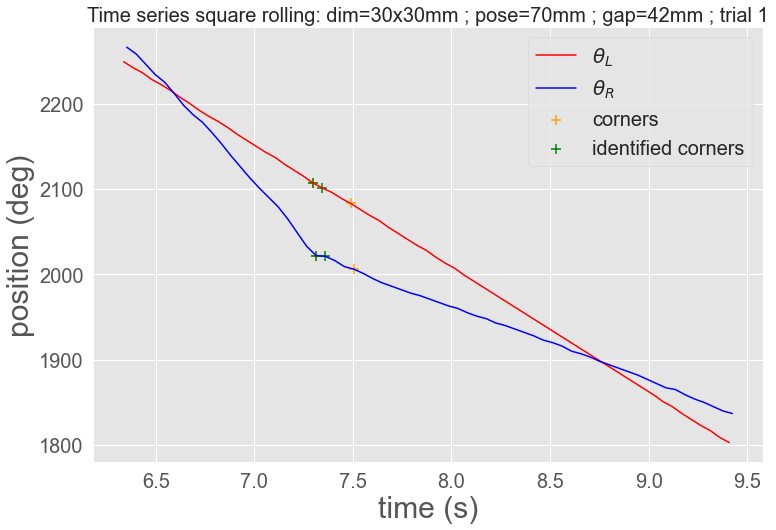

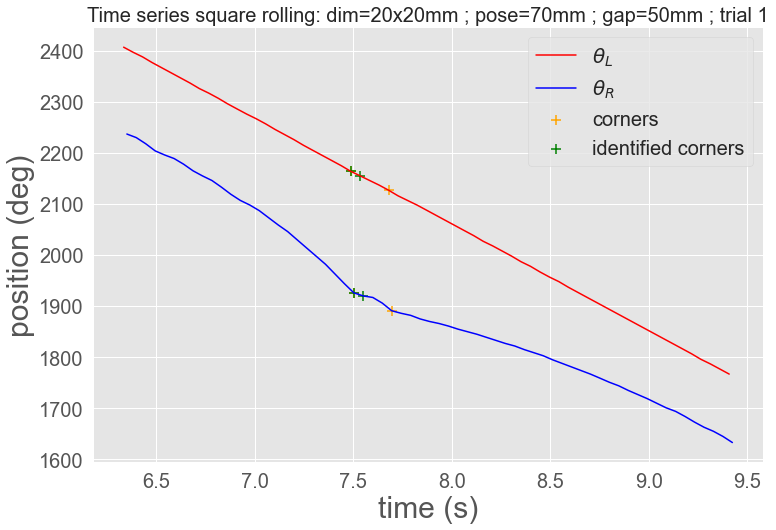

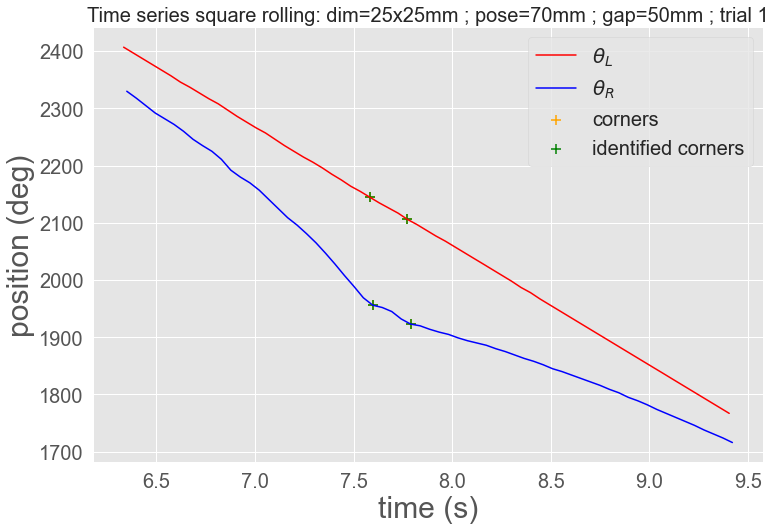

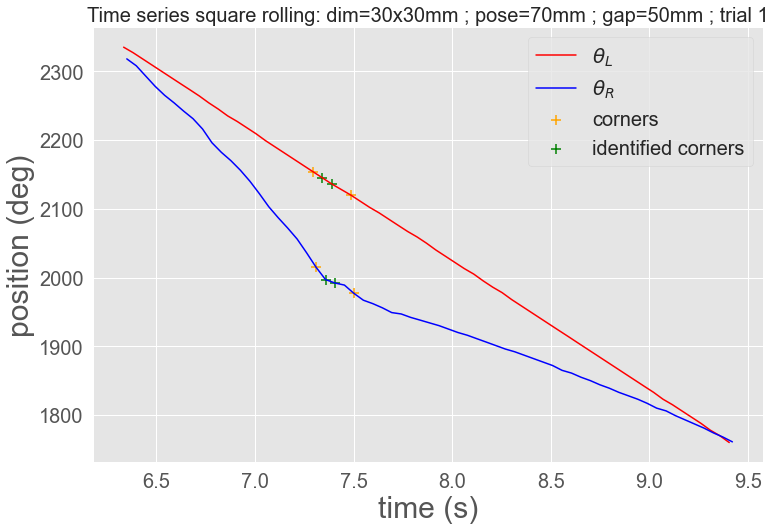

In [36]:
with open('data_sqrt_trial_classified.json') as f:
    full_data_dict = json.load(f)

poses_drf = [60,65,70]
finger_gaps = [34,42,50]
sqrt_sides = [20,25,30]
trials = [1,2]
data_list=[[],[]]

for trial in trials:
    for pose in poses_drf:
        for gap in finger_gaps:
            for dim in sqrt_sides:
                dict_key = "dim_"+str(dim)+"_pose_"+str(pose)+"_gap_"+str(gap)+'_'+str(trial)
                data_dict = full_data_dict[dict_key]
    
                data_list = [data_dict['LF_motion1'][3:],data_dict['RF_motion1'][3:]]
                data_array = np.array(data_list).T

                temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,1,:,0],axis=0)
                temp_data_array = np.append(temp_data_array,data_array[np.newaxis,0,:,1],axis=0)
                temp_data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0)
                data_array = np.append(temp_data_array,data_array[np.newaxis,2,:,0],axis=0).T
                angle_array = data_array[:,:4].astype(float)
                class_array = data_array[:,4]

                # 1st derivative
                # we only keep the value of the right finger because it is the follower
                gradient = []
                for i in range(1,angle_array.shape[0]-1):
                    rate_change = (angle_array.T[2][i+1]-angle_array.T[2][i-1])/(angle_array.T[3][i+1]-angle_array.T[3][i-1])
                    gradient += [round(rate_change,3)]
                
                # 2nd derivative
                double_gradient = []
                for i in range(len(gradient)-1):
                    rate_change = (gradient[i+1]-gradient[i])/(angle_array.T[3][i+1]-angle_array.T[3][i-1])
                    double_gradient += [round(rate_change,3)]
                
                # identified corners
                index_max_double_gradient = np.absolute(double_gradient).argsort()[-2:][::-1]+2
                identified_corner = [angle_array[index_max_double_gradient[0]],
                                     angle_array[index_max_double_gradient[1]]]
                
                ##### PLOT FUNCTIONS #####
                # ANGLE RELATIONS
                #corrner_id_angles(angle_array,identified_corners,dim,pose,gap,img)
                # TIME SERIES
                corrner_id_time_series(angle_array,class_array,identified_corner,dim,pose,gap,img)
            